Overview:
In this third practical application assignment, your goal is to compare the performance of the classifiers 
(k-nearest neighbors, logistic regression, decision trees, and support vector machines) you encountered in this section 
of the program. You will use a dataset related to the marketing of bank products over the telephone.

Data:
The dataset you will use comes from the UCI Machine Learning repository. The data is from a Portuguese banking institution 
and is a collection of the results of multiple marketing campaigns.  The classification goal is to predict if the client 
will subscribe a term deposit. The marketing campaigns were based on phone calls. Often, more than one contact to the same
client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.  The
samples were acquired over a period of more than 2 years (May 2008 to November 2010).



In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import set_config
set_config(display = 'diagram')
import warnings
warnings.filterwarnings("ignore")
import time


In [2]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')
orig_df = df.copy()
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Understanding the features
1. age - numeric
2. job - Type of job/occupation - categorical
3. marital - Marital status - categorical
4. education - Education level - categorical
5. default - has credit in default? - Binary
6. balance - Average yearly balance - numeric
7. housing - has housing loan? - Binary
8. loan - has personal loan? - Binary
9. contact - contact communication type - Categorical
10. day_of_week - Last contact day of the week - Date
11. month - Last contact month of year - Date
12. duration - Last contact duration in seconds - numeric
13. campaign - Number of contacts done during the campaign and for this client - numeric
14. pdays - Number of days that passed by after the client was last contacted from a previous campaign - numeric
15. previous - number of contacts performed before this campaign and for this client - numeric
16. poutcome - outcome of the previous marketing campaign - Categorical
17. y - outcome - has the client subscribed a term deposit? - Binary

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
#Checking for duplicate values
sum(df.duplicated())

12

In [5]:
#Dropping duplicate values
df = df.drop_duplicates()
df.shape

(41176, 21)

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10419,24921,12164,32577,21571,33938,26135,13767,8618,35551,36537


In [8]:
df = df.drop(['euribor3m','emp.var.rate'], axis = 1)

In [9]:
df['age'].value_counts(normalize = True)

age
31    0.047285
32    0.044808
33    0.044516
36    0.043205
35    0.042695
        ...   
89    0.000049
91    0.000049
94    0.000024
87    0.000024
95    0.000024
Name: proportion, Length: 78, dtype: float64

In [10]:
df['job'].value_counts(normalize = True)

job
admin.           0.253036
blue-collar      0.224718
technician       0.163663
services         0.096343
management       0.071012
retired          0.041723
entrepreneur     0.035360
self-employed    0.034510
housemaid        0.025743
unemployed       0.024626
student          0.021250
unknown          0.008014
Name: proportion, dtype: float64

In [11]:
df['marital'].value_counts()   

marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64

In [12]:
df['education'].value_counts()

education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64

In [13]:
df['default'].value_counts(normalize = True)

default
no         0.791165
unknown    0.208762
yes        0.000073
Name: proportion, dtype: float64

In [14]:
df['housing'].value_counts()

housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64

In [15]:
df['loan'].value_counts()

loan
no         33938
yes         6248
unknown      990
Name: count, dtype: int64

In [16]:
df['contact'].value_counts()

contact
cellular     26135
telephone    15041
Name: count, dtype: int64

In [17]:
df['y'].value_counts(normalize = True)

y
no     0.887337
yes    0.112663
Name: proportion, dtype: float64

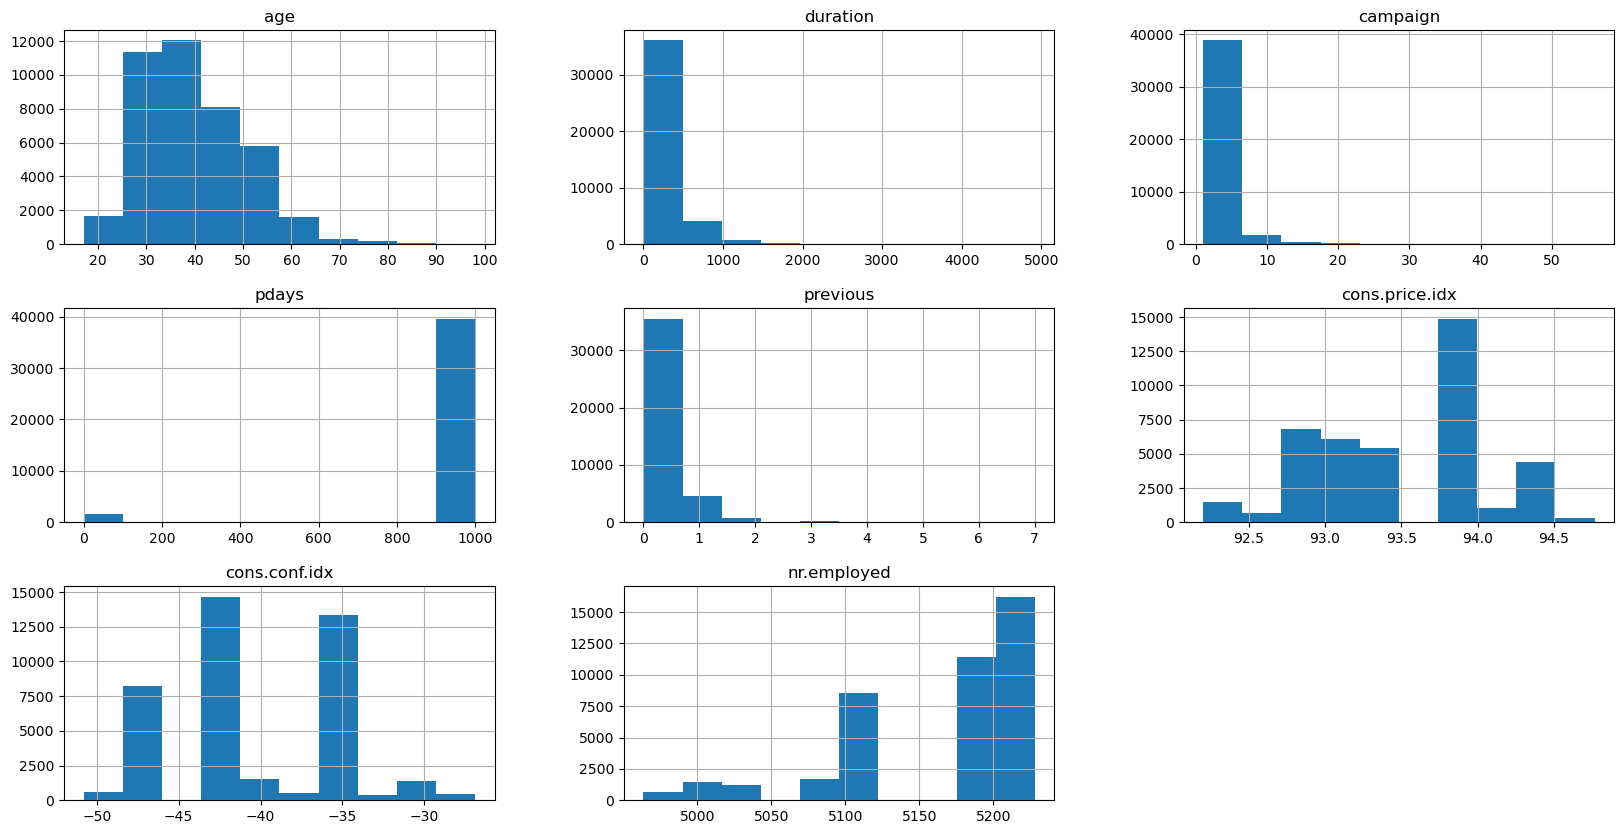

In [18]:
df.hist(figsize = (20,10));

In [19]:
num_columns = df.select_dtypes(['int', 'float']).columns.tolist()
num_columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'cons.price.idx',
 'cons.conf.idx',
 'nr.employed']

In [20]:
cat_columns = df.select_dtypes('object').columns.tolist()
cat_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

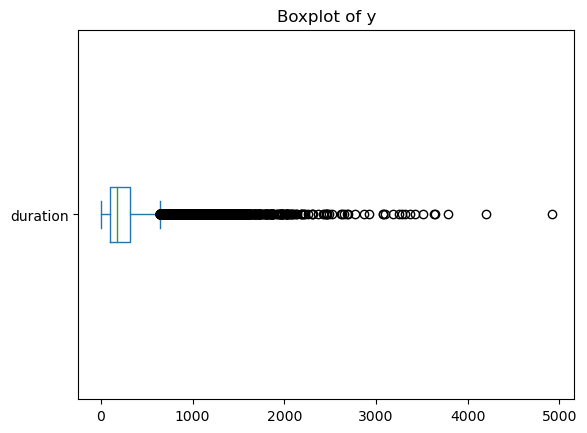

In [21]:
#Checking for outliers in each categories by plotting them
df['duration'].plot(kind = 'box', vert = False, title = "Boxplot of y");

In [22]:
#Drop the ones which are insignificant
df_zscore = df[np.abs(stats.zscore(df['duration'])) < 3].copy()

<Axes: title={'center': 'Boxplot of msrp after outlier removal: z-score'}>

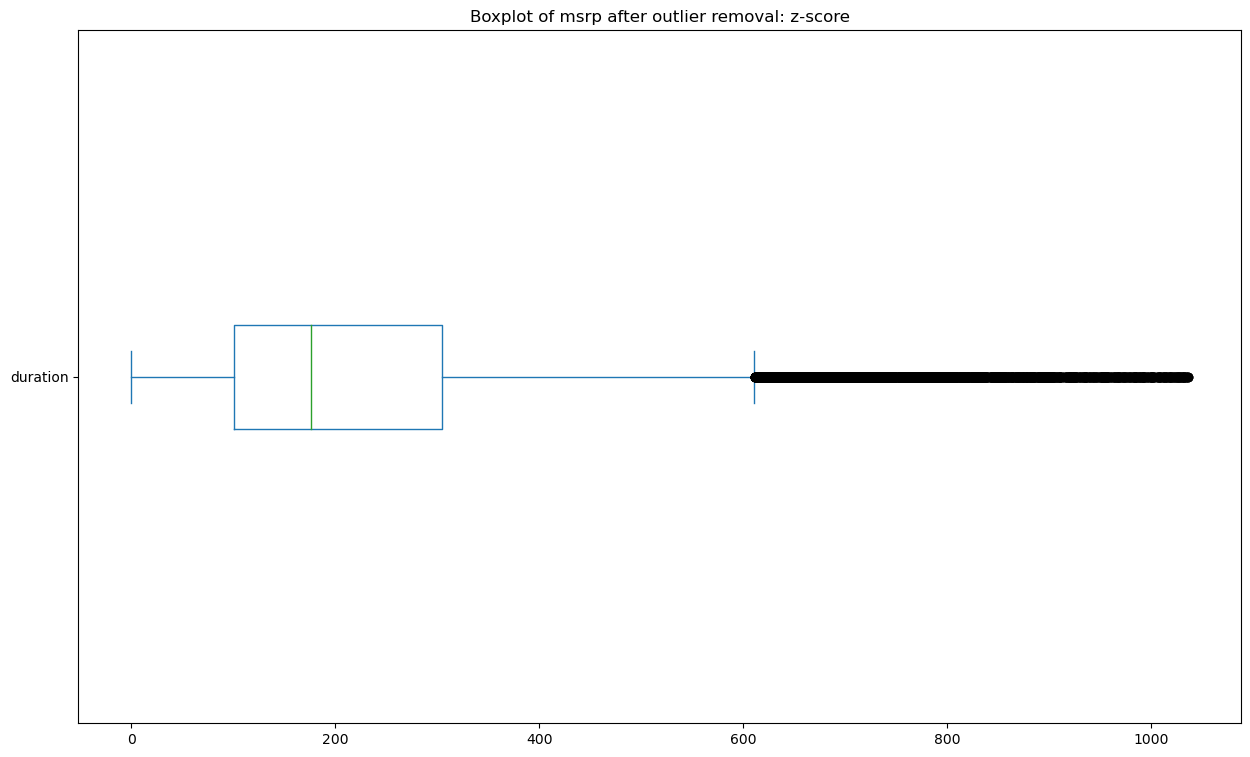

In [23]:
df_zscore['duration'].plot(kind = 'box', vert = False, title = "Boxplot of msrp after outlier removal: z-score", figsize = (15,9))

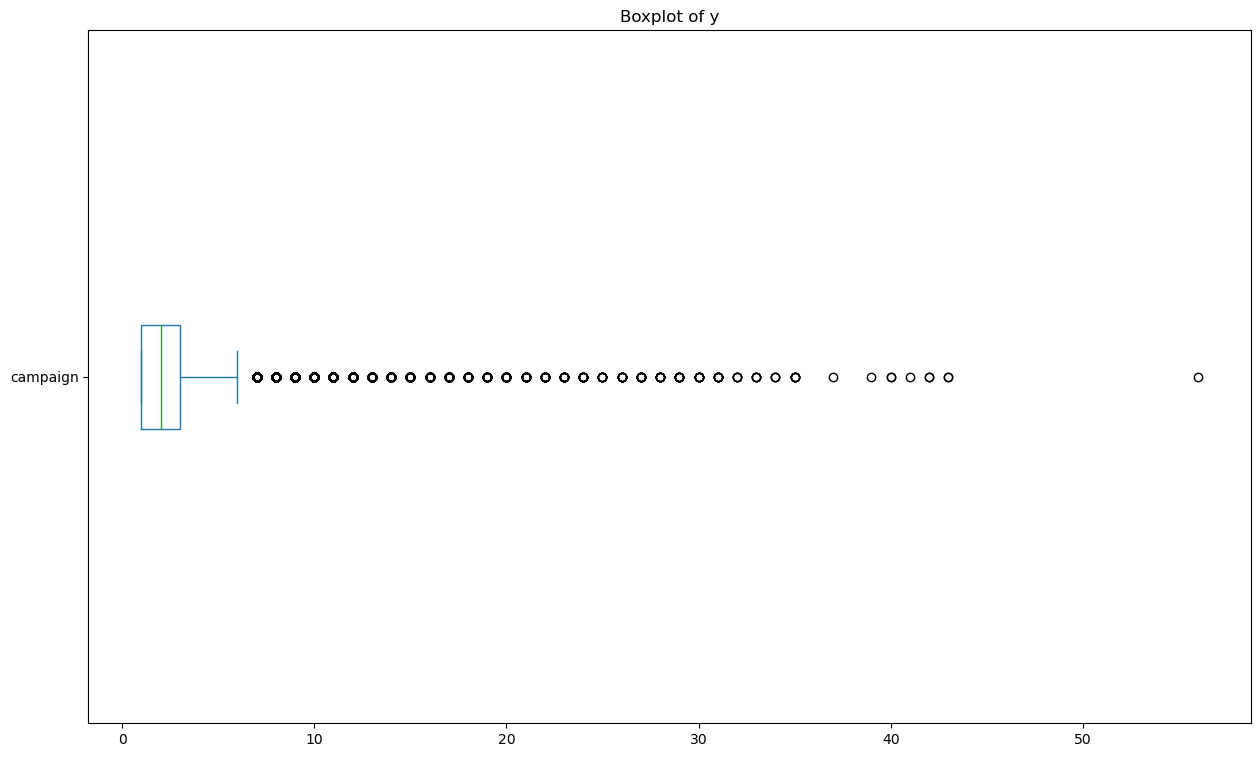

In [24]:
df['campaign'].plot(kind = 'box', vert = False, title = "Boxplot of y", figsize = (15,9));

In [25]:
df_zscore = df[np.abs(stats.zscore(df['campaign'])) < 3].copy()

In [26]:
df = df_zscore
df_wo_outliers = df.copy()

In [27]:
df['y'] = df['y'].map({'yes':1 ,'no':0})

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40307 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             40307 non-null  int64  
 1   job             40307 non-null  object 
 2   marital         40307 non-null  object 
 3   education       40307 non-null  object 
 4   default         40307 non-null  object 
 5   housing         40307 non-null  object 
 6   loan            40307 non-null  object 
 7   contact         40307 non-null  object 
 8   month           40307 non-null  object 
 9   day_of_week     40307 non-null  object 
 10  duration        40307 non-null  int64  
 11  campaign        40307 non-null  int64  
 12  pdays           40307 non-null  int64  
 13  previous        40307 non-null  int64  
 14  poutcome        40307 non-null  object 
 15  cons.price.idx  40307 non-null  float64
 16  cons.conf.idx   40307 non-null  float64
 17  nr.employed     40307 non-null  floa

Business Objective
To identify the main features that determine the success of the marketing campaign. This would give us help to increase the marketing campaign efficiency to more effectively reach out to the more probable customers and allocating the resources accordingly. 

In [29]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,93.994,-36.4,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,93.994,-36.4,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,93.994,-36.4,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,93.994,-36.4,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,93.994,-36.4,5191.0,0
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,93.994,-36.4,5191.0,0
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,93.994,-36.4,5191.0,0
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,93.994,-36.4,5191.0,0
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,93.994,-36.4,5191.0,0
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,93.994,-36.4,5191.0,0


<Axes: xlabel='job'>

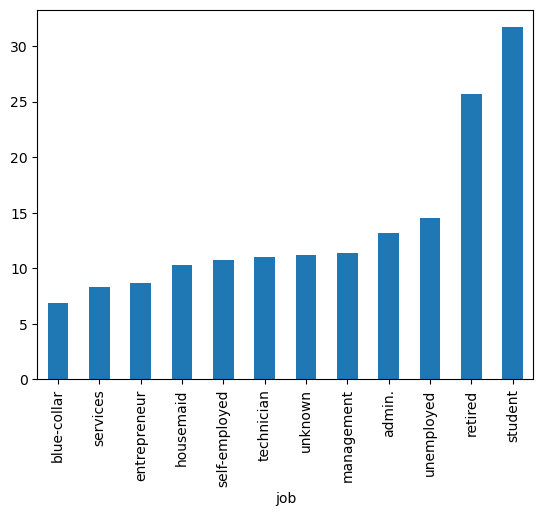

In [30]:
df.groupby('job')['y'].mean().round(3).multiply(100).sort_values().plot(kind = 'bar')

<Axes: xlabel='nr.employed'>

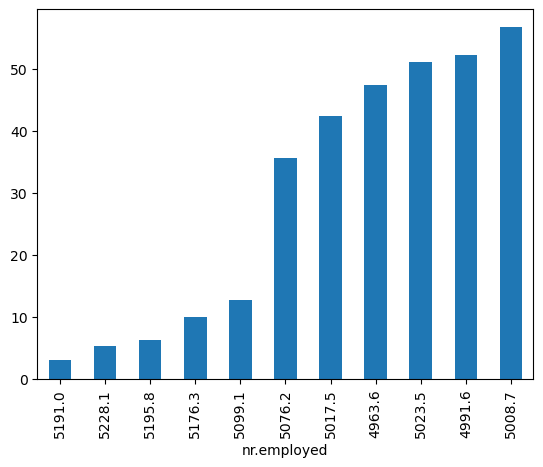

In [31]:
df.groupby('nr.employed')['y'].mean().round(3).multiply(100).sort_values().plot(kind = 'bar')

<Axes: xlabel='pdays'>

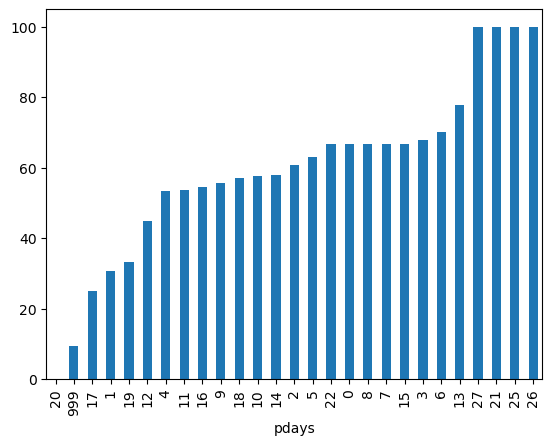

In [32]:
df.groupby('pdays')['y'].mean().round(3).multiply(100).sort_values().plot(kind = 'bar')

<Axes: xlabel='age'>

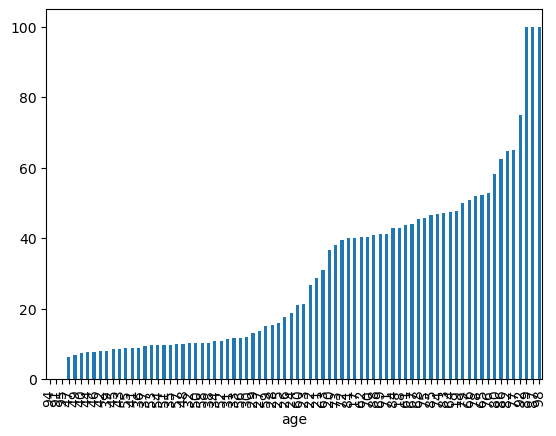

In [33]:
df.groupby('age')['y'].mean().round(3).multiply(100).sort_values().plot(kind = 'bar')

Split the data and scaling. Afterwards do OneHot Encoding

In [34]:
X = df[num_columns]
y = df.y

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = 42)

In [36]:
scaler = StandardScaler()

In [37]:
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

In [38]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X.columns)

In [39]:
X_cat_encoded = pd.get_dummies(df[['job','marital', 'education','default', 'housing', 'loan']], drop_first = True)

In [40]:
X_cat_encoded

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,False,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
41184,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
41185,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
41186,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False


In [41]:
dummy = DummyClassifier().fit(X_train_scaled, y_train)


baseline = dummy.score(X_train_scaled, y_train)
baseline_test = dummy.score(X_test_scaled, y_test)

# Predictions on test 
print("Training score is {:.2f}".format(baseline))
print("Test score is {:.2f}".format(baseline_test))

# rmse
dummy_pred = dummy.predict(X_test_scaled)
baseline_rmse = mean_squared_error(y_test, dummy_pred, squared = False)
print("The value of dummy rmse is {:.2f}".format(baseline_rmse))

Training score is 0.89
Test score is 0.89
The value of dummy rmse is 0.34


Simple Logistic Regression Model

In [42]:
logparams={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

In [43]:
logreg = GridSearchCV(LogisticRegression(), param_grid = logparams).fit(X_train_scaled, y_train)
print(logreg.best_score_)
print(logreg.best_params_)

0.9083434392432694
{'C': 10.0, 'penalty': 'l2'}


In [44]:
log_model = LogisticRegression(penalty = 'l2', C = 10.0)
start = time.time()
log_model.fit(X_train_scaled, y_train)
stop = time.time()
log_train_time = stop - start
log_pred = log_model.predict(X_test_scaled)

In [45]:
print('Training Score: {:.2f}'.format(logreg.score(X_train_scaled, y_train)))
print('Test Score: {:.2f}'.format( logreg.score(X_test_scaled, y_test)))
print('Logistic Regression rmse: {:.2f}'.format(mean_squared_error(y_test, logreg.predict(X_test_scaled), squared = False)))
#print(classification_report(y_test, log_pred))
print('Precision Score: {:.2f}'.format(precision_score(y_test, log_pred,average = 'binary')))

Training Score: 0.91
Test Score: 0.91
Logistic Regression rmse: 0.31
Precision Score: 0.65


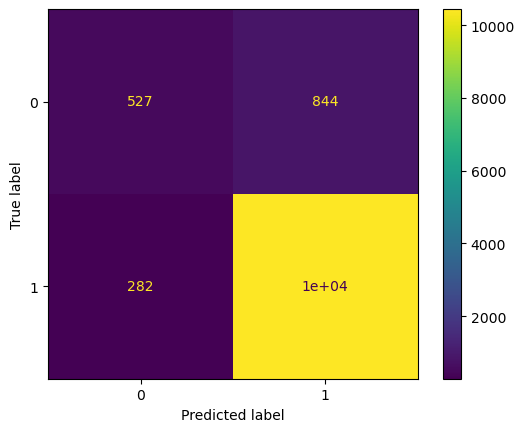

In [46]:
test_preds = logreg.predict(X_test_scaled)
confusion_mat = confusion_matrix(y_test, test_preds, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['0', '1' ])
disp.plot()
plt.show()

KNN (k-nearest neighbors) Model

In [47]:
knnparams = {'n_neighbors': [9,10,11,12]}

In [48]:
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid = knnparams).fit(X_train_scaled, y_train)
best_k = list(knn_grid.best_params_.values())
best_acc = knn_grid.score(X_test_scaled, y_test)
knn_train_acc = knn_grid.score(X_train_scaled, y_train)
knn_test_acc = knn_grid.score(X_test_scaled, y_test)
best_params = knn_grid.best_params_
print(best_acc)

print (f'Best Parameters: {best_params}')
print (f'Training Accuracy: {knn_train_acc: .2f}')
print (f'Test Accuracy: {knn_test_acc: .2f}')

0.9047382783428429
Best Parameters: {'n_neighbors': 11}
Training Accuracy:  0.92
Test Accuracy:  0.90


In [49]:
knn_model = KNeighborsClassifier(n_neighbors = 11)
start = time.time()
knn_model.fit(X_train_scaled, y_train)
stop = time.time()
knn_train_time = stop - start
knn_pred = knn_model.predict(X_test_scaled)
print(f'Test Accuracy: {knn_model.score(X_test_scaled, y_test): .2f}')
print(f'Training time: {knn_train_time: .3f}s')
print('Precision Score: {:.2f}'.format(precision_score(y_test, knn_pred, average = 'binary')))

Test Accuracy:  0.90
Training time:  0.055s
Precision Score: 0.60


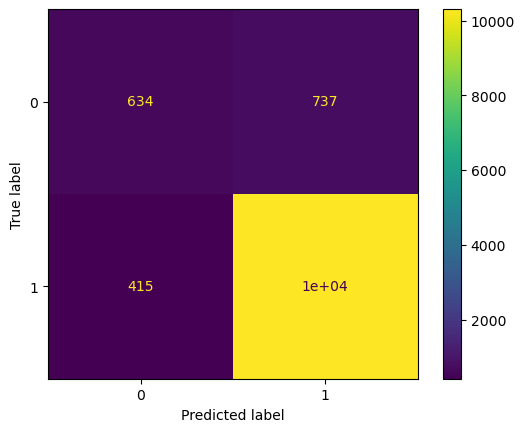

In [50]:
confusion_mat = confusion_matrix(y_test, knn_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['0', '1' ])
disp.plot()
plt.show()

Decision Tree model

In [51]:
treeparams = {'min_impurity_decrease': [.01, .02, .03, .05, 1.0],
         'max_depth': [2,3,4,5,6]}

In [52]:
grid = GridSearchCV(DecisionTreeClassifier(), param_grid = treeparams).fit(X_train_scaled, y_train)
grid_train_acc = grid.score(X_train_scaled, y_train)
grid_test_acc = grid.score(X_test_scaled, y_test)
best_params = grid.best_params_
best_acc = grid.score(X_test_scaled, y_test)
results = pd.DataFrame(grid.predict(X_test_scaled))
print(best_acc)

print (f'Best Parameters: {best_params}')
print (f'Training Accuracy: {grid_train_acc: .2f}')
print (f'Test Accuracy: {grid_test_acc: .2f}')

0.9012651947407592
Best Parameters: {'max_depth': 2, 'min_impurity_decrease': 0.01}
Training Accuracy:  0.90
Test Accuracy:  0.90


In [53]:
tree_model = DecisionTreeClassifier(max_depth = 2, min_impurity_decrease = .01)
start = time.time()
tree_model.fit(X_train_scaled, y_train)
stop = time.time()
tree_train_time = stop - start
tree_pred = tree_model.predict(X_test_scaled)
print(f'Test Accuracy: {tree_model.score(X_test_scaled, y_test): .2f}')
print(f'Training time: {tree_train_time: .3f}s')
print('Precision Score: {:.2f}'.format(precision_score(y_test, tree_pred, average = 'binary')))

Test Accuracy:  0.90
Training time:  0.027s
Precision Score: 0.60


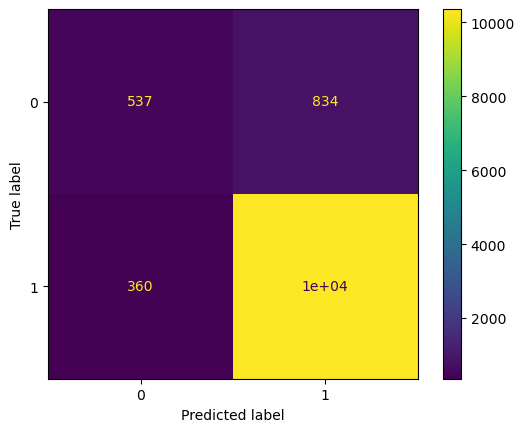

In [54]:
confusion_mat = confusion_matrix(y_test, tree_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['0', '1' ])
disp.plot()
plt.show()

SVM (Support Vector Machines) model

In [55]:
svc_model = SVC()
start = time.time()
svc_model.fit(X_train_scaled, y_train)
stop = time.time()
svc_train_time = stop - start
svc_pred = svc_model.predict(X_test_scaled)
svc_train_score = svc_model.score(X_train_scaled, y_train)
svc_test_score = svc_model.score(X_test_scaled, y_test)
print (f'Training Accuracy: {svc_train_score: .2f}')
print (f'Test Accuracy: {svc_test_score: .2f}')
print(f'Training time: {svc_train_time: .3f}s')
print('Precision Score: {:.2f}'.format(precision_score(y_test, svc_pred, average = 'binary')))

Training Accuracy:  0.91
Test Accuracy:  0.91
Training time:  6.596s
Precision Score: 0.66


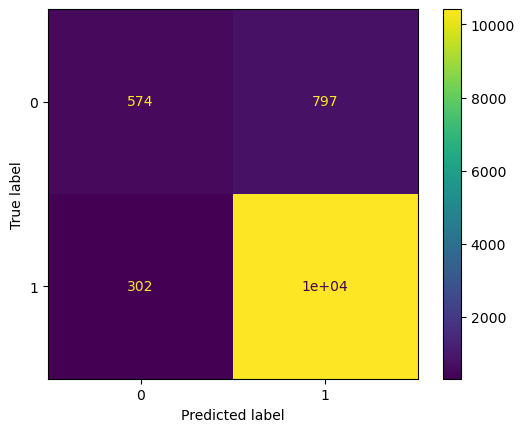

In [56]:
confusion_mat = confusion_matrix(y_test, svc_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['0', '1' ])
disp.plot()
plt.show()

Comparing the models

In [57]:
info = [['Logistic Regression', log_train_time, 
                                log_model.score(X_train_scaled, y_train),
                                log_model.score(X_test_scaled, y_test),
                                precision_score(y_test, log_pred)],
        ['KNN', knn_train_time, 
                knn_model.score(X_train_scaled, y_train),
                knn_model.score(X_test_scaled, y_test),
                precision_score(y_test, knn_pred)],
        ['Decision Tree', tree_train_time, 
                          tree_model.score(X_train_scaled, y_train),
                          tree_model.score(X_test_scaled, y_test),
                          precision_score(y_test, tree_pred)],
        ['SVM',svc_train_time, 
               svc_train_score, 
               svc_test_score,
               precision_score(y_test, svc_pred)]]

df2 = pd.DataFrame(info, 
            columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy', 'Precision'])
df2

,Model,Train Time,Train Accuracy,Test Accuracy,Precision
0,Logistic Regression,0.031380,0.908450,0.906888,0.651422
1,KNN,0.055146,0.919650,0.904738,0.604385
2,Decision Tree,0.026905,0.903381,0.901265,0.598662
3,SVM,6.595692,0.913873,0.909121,0.655251


Checking the correlation

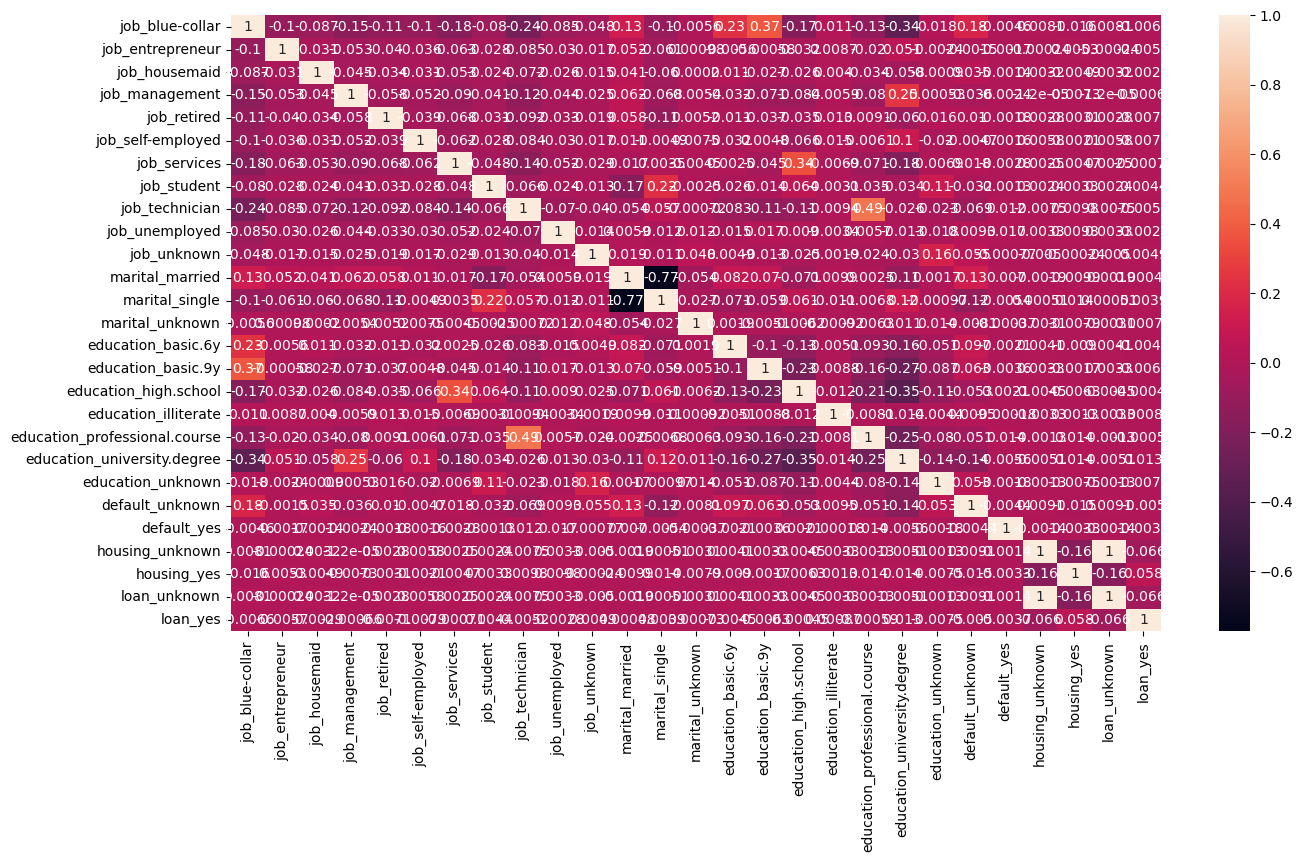

In [58]:
plt.figure(figsize = (15,8))
sns.heatmap(X_cat_encoded.corr(), annot = True);

Improving the models using GridSearchCV and modifying the Decision boundary

Logistic Regression

In [59]:
logreg = GridSearchCV(LogisticRegression(), param_grid = logparams, scoring = 'precision')
start = time.time()
logreg.fit(X_train_scaled, y_train)
stop = time.time()
log_train_time = stop - start
print(logreg.best_score_)
print(logreg.best_params_)

0.7160573488364835
{'C': 0.001, 'penalty': 'l2'}


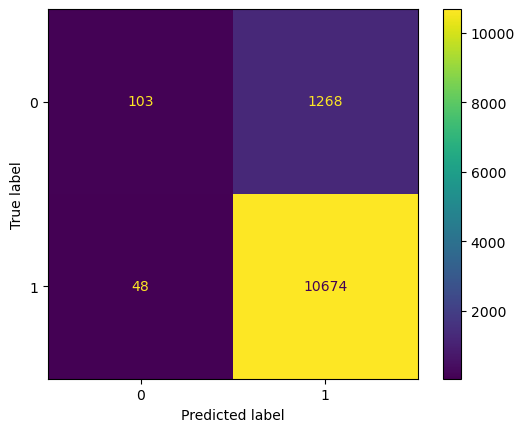

Accuracy Score: 0.89
Precision Score: 0.68


In [60]:
log_model = LogisticRegression(penalty = 'l2', C = .001).fit(X_train_scaled, y_train)
log_pred = np.where(log_model.predict_proba(X_test_scaled)[:,1] > .75,1,0)

confusion_mat = confusion_matrix(y_test, log_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['0', '1' ])
disp.plot()
plt.show()

print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, log_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, log_pred, average = 'binary')));

KNN

In [61]:
knnreg = GridSearchCV(KNeighborsClassifier(), param_grid = knnparams, scoring = 'precision')
start = time.time()
knnreg.fit(X_train_scaled, y_train)
stop = time.time()
log_train_time = stop - start
print(knnreg.best_score_)
print(knnreg.best_params_)
print(log_train_time)

0.6517707602711768
{'n_neighbors': 10}
6.534162998199463


Accuracy Score: 0.89
Precision Score: 0.85


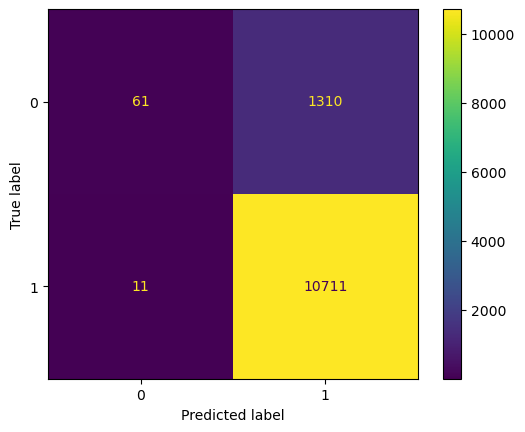

In [62]:
knn_model = KNeighborsClassifier(n_neighbors = 12).fit(X_train_scaled, y_train)
knn_pred = np.where(knn_model.predict_proba(X_test_scaled)[:,1] > .85,1,0)
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, knn_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, knn_pred, average = 'binary')));

confusion_mat = confusion_matrix(y_test, knn_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['0', '1' ])
disp.plot()
plt.show()

Decision Tree

In [63]:
treereg = GridSearchCV(DecisionTreeClassifier(), param_grid = treeparams, scoring = 'precision')
start = time.time()
treereg.fit(X_train_scaled, y_train)
stop = time.time()
log_train_time = stop - start
print(treereg.best_score_)
print(treereg.best_params_)
print(log_train_time)

0.6130143797789278
{'max_depth': 2, 'min_impurity_decrease': 0.01}
2.067307949066162


Accuracy Score: 0.90
Precision Score: 0.60


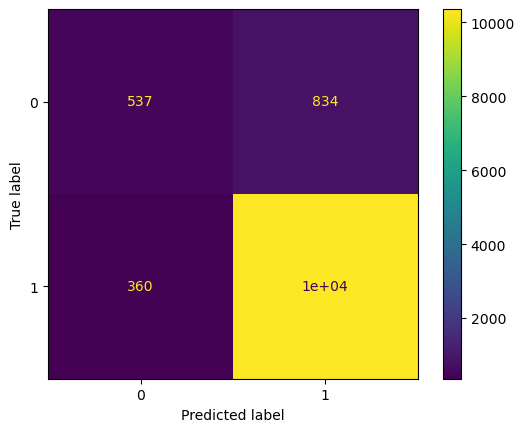

In [64]:
tree_model = DecisionTreeClassifier(max_depth = 2, min_impurity_decrease = .01).fit(X_train_scaled, y_train)
tree_pred = np.where(tree_model.predict_proba(X_test_scaled)[:,1] > .60,1,0)
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, tree_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, tree_pred, average = 'binary')));

confusion_mat = confusion_matrix(y_test, tree_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['0', '1' ])
disp.plot()
plt.show()

SVM

Accuracy Score: 0.90
Precision Score: 0.76
40.88795781135559


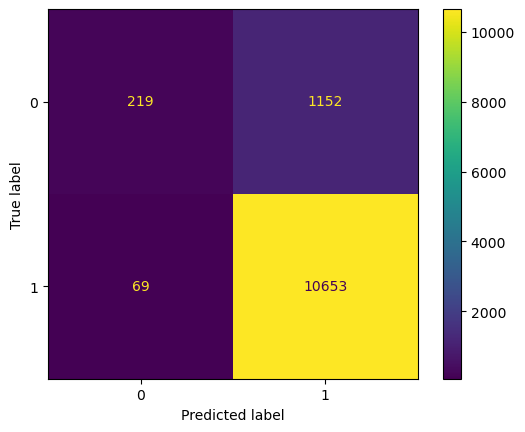

In [65]:
svc_model = SVC(probability = True).fit(X_train_scaled, y_train)
start = time.time()
#fitted twice, once to avoid predict_proba "not fitted" error, and second to count time
svc_model.fit(X_train_scaled, y_train)  
stop = time.time()
log_train_time = stop - start
svc_pred = np.where(svc_model.predict_proba(X_test_scaled)[:,1] > .85,1,0)

print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, svc_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, svc_pred, average = 'binary')))
print(log_train_time)

confusion_mat = confusion_matrix(y_test, svc_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['0', '1' ])
disp.plot()
plt.show()

Comparing the improved models

In [66]:
info = [['Logistic Regression', log_train_time, 
                                accuracy_score(y_test, log_pred),
                                precision_score(y_test, log_pred, average = 'binary')],
        ['KNN', knn_train_time, 
                accuracy_score(y_test, knn_pred),
                precision_score(y_test, knn_pred, average = 'binary')],
        ['Decision Tree', tree_train_time, 
                          accuracy_score(y_test, tree_pred),
                          precision_score(y_test, tree_pred, average = 'binary')],
        ['SVM',svc_train_time, 
               accuracy_score(y_test, svc_pred),
               precision_score(y_test, svc_pred, average = 'binary')]]
# Create the pandas DataFrame with column name is provided explicitly
df3 = pd.DataFrame(info, 
            columns=['Model', 'Train Time','Test Accuracy', 'Test Precision'])
df3

,Model,Train Time,Test Accuracy,Test Precision
0,Logistic Regression,40.887958,0.891177,0.682119
1,KNN,0.055146,0.890763,0.847222
2,Decision Tree,0.026905,0.901265,0.598662
3,SVM,6.595692,0.899032,0.760417


From thg eGrid, it is seen that, KNN would be the best model to use with 89% Accuracy and 84% Precision

Conclusion

From the analysis, we can see that the following features seem to have more of an effect on the outcome

1. duration : Duration of marketing calls have a positive correlation. The more time spent on the call with the customer, the more they tend to subscribe
2. pdays : Number of days that passed by after the client was last contacted from a previous campaign - The less the number of days , the better is the subscription
3. age - Even though the correlation is not so strong with age, still the individuals in the 40-50 category tend to subscribe more
4. previous - Number of contacts performed before this campaign for this client - Decently strong correlation , the more the contact the better the subscription
